<a href="https://colab.research.google.com/github/pshemach/Computer-Vision/blob/main/Transfer_Learning_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('Hello World,')

Hello World,


In [2]:
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
import numpy as np

In [3]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-02-29 02:55:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 173.194.217.207, 173.194.218.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  27.0MB/s    in 2.4s    

2024-02-29 02:55:52 (27.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
zip_ref = zipfile.ZipFile('cats_and_dogs_filtered.zip','r')
zip_ref.extractall()
zip_ref.close()

In [5]:
for dirpath, dirname, filenames in os.walk('cats_and_dogs_filtered'):
  print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 1 images in cats_and_dogs_filtered
There are 2 directories and 0 images in cats_and_dogs_filtered/validation
There are 0 directories and 500 images in cats_and_dogs_filtered/validation/dogs
There are 0 directories and 500 images in cats_and_dogs_filtered/validation/cats
There are 2 directories and 0 images in cats_and_dogs_filtered/train
There are 0 directories and 1000 images in cats_and_dogs_filtered/train/dogs
There are 0 directories and 1000 images in cats_and_dogs_filtered/train/cats


In [6]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

validation_data = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                              shuffle=True,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
class_names = train_data.class_names

In [10]:
len(train_data), len(validation_data)

(63, 32)

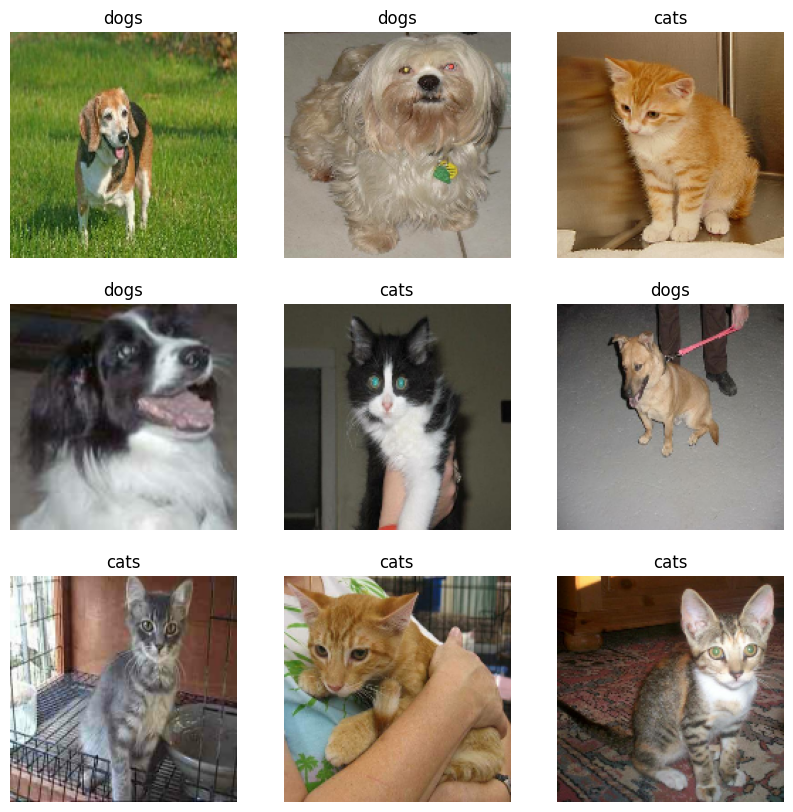

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
val_batches = tf.data.experimental.cardinality(validation_data)
test_data = validation_data.take(val_batches//5)
validation_data = validation_data.skip(val_batches//5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 26
Number of test batches: 6


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

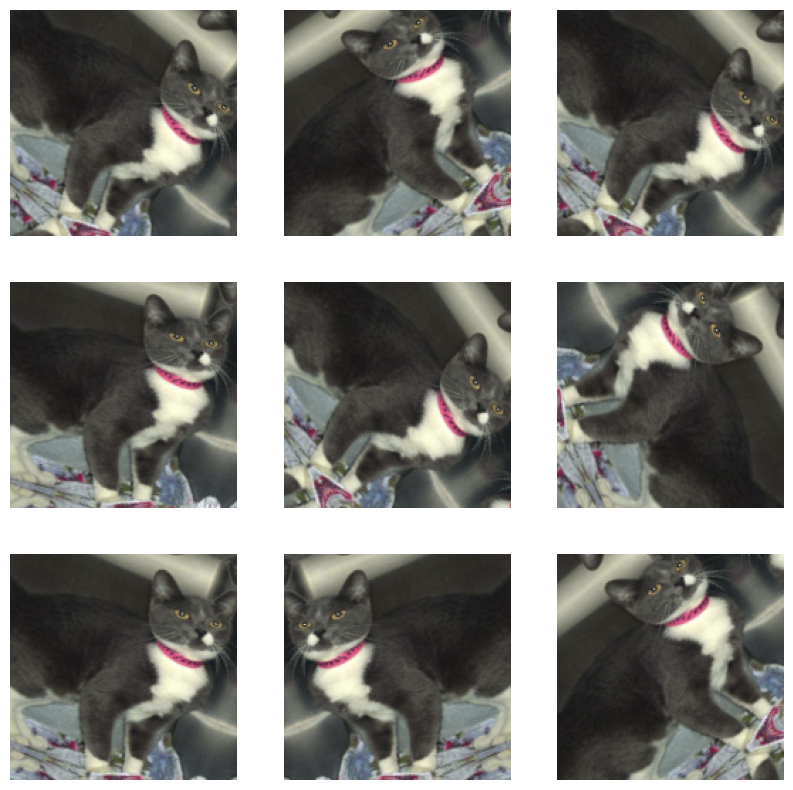

In [16]:
plt.figure(figsize=(10,10))
for images, _ in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(images[0], 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale = tf.keras.layers.Rescaling(1./127.5,offset=-1)

In [19]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [22]:
base_model.trainable = False

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(1)

In [26]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs,outputs)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [28]:
len(model.trainable_variables)

2

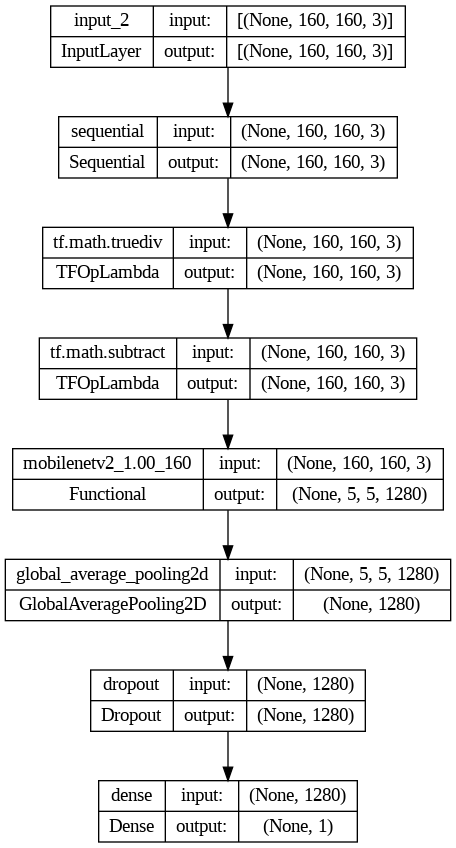

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
base_lr = 0.0001

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy'))

In [31]:
loss0, accuracy0 = model.evaluate(validation_data)

26/26 [==============================] - 22s 606ms/step - loss: 0.7972 - accuracy: 0.5285


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.53


In [33]:
epochs = 10

history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=validation_data)

Epoch 1/10
63/63 [==============================] - 60s 905ms/step - loss: 0.7047 - accuracy: 0.6080 - val_loss: 0.4919 - val_accuracy: 0.8057
Epoch 2/10
63/63 [==============================] - 65s 1s/step - loss: 0.5119 - accuracy: 0.7585 - val_loss: 0.3598 - val_accuracy: 0.9072
Epoch 3/10
63/63 [==============================] - 60s 939ms/step - loss: 0.4147 - accuracy: 0.8410 - val_loss: 0.2810 - val_accuracy: 0.9480
Epoch 4/10
63/63 [==============================] - 62s 985ms/step - loss: 0.3455 - accuracy: 0.8715 - val_loss: 0.2329 - val_accuracy: 0.9616
Epoch 5/10
63/63 [==============================] - 62s 979ms/step - loss: 0.3077 - accuracy: 0.8850 - val_loss: 0.2005 - val_accuracy: 0.9629
Epoch 6/10
63/63 [==============================] - 63s 1s/step - loss: 0.2733 - accuracy: 0.9040 - val_loss: 0.1737 - val_accuracy: 0.9740
Epoch 7/10
63/63 [==============================] - 63s 1s/step - loss: 0.2546 - accuracy: 0.9080 - val_loss: 0.1568 - val_accuracy: 0.9740
Epoch 8/

In [34]:
model.evaluate(validation_data)

26/26 [==============================] - 21s 797ms/step - loss: 0.1232 - accuracy: 0.9752


[0.12315403670072556, 0.9752475023269653]

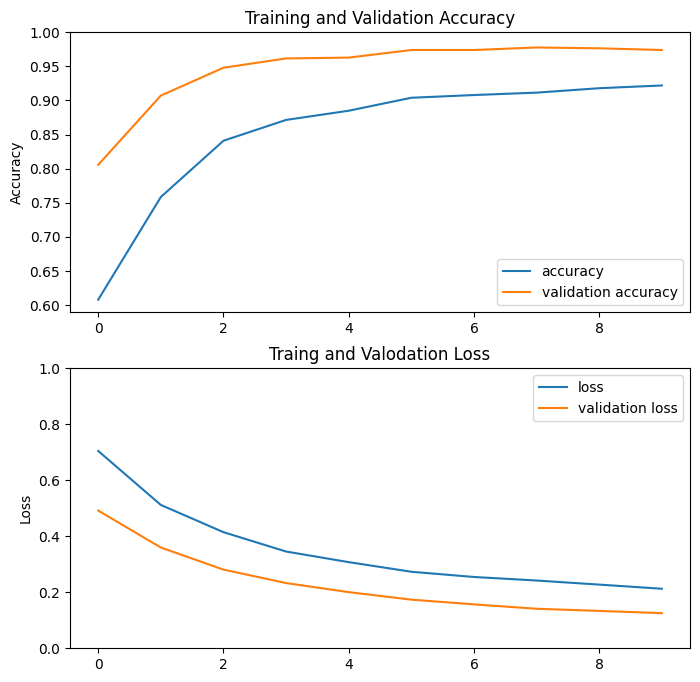

In [35]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([min(plt.ylim()),1])


plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Traing and Valodation Loss')
plt.ylim([0,1.0])
plt.show()

In [42]:
base_model.trainable = True

In [45]:
print(f'Number of layers in the base model: {len(base_model.layers)}')

Number of layers in the base model: 154


In [46]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy'))

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [49]:
len(model.trainable_variables)

56

In [51]:
fine_tune_epochs = 10

total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data)

Epoch 10/20
63/63 [==============================] - 100s 1s/step - loss: 0.1534 - accuracy: 0.9420 - val_loss: 0.0654 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 93s 1s/step - loss: 0.1182 - accuracy: 0.9535 - val_loss: 0.0425 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 88s 1s/step - loss: 0.1135 - accuracy: 0.9500 - val_loss: 0.0437 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 133s 2s/step - loss: 0.0836 - accuracy: 0.9685 - val_loss: 0.0380 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 83s 1s/step - loss: 0.0846 - accuracy: 0.9675 - val_loss: 0.0323 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 92s 1s/step - loss: 0.0755 - accuracy: 0.9680 - val_loss: 0.0363 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 80s 1s/step - loss: 0.0639 - accuracy: 0.9720 - val_loss: 0.0382 - val_accuracy: 0.9876
Epoch 17/20

In [52]:
accuracy += history_fine.history['accuracy']
val_accuracy += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

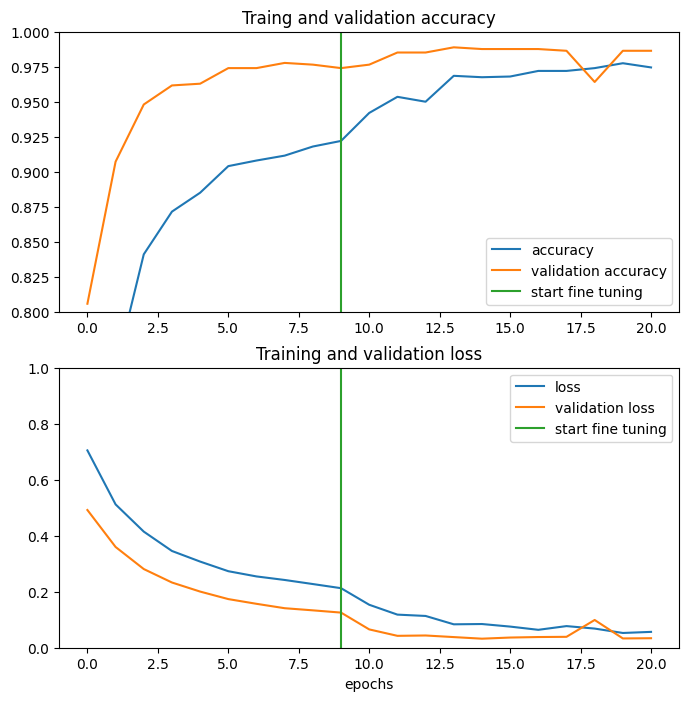

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.ylim([0.8,1])
plt.plot([epochs-1,epochs-1],plt.ylim(), label='start fine tuning')
plt.legend(loc='lower right')
plt.title('Traing and validation accuracy')


plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.ylim([0,1.0])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='start fine tuning')
plt.legend(loc='upper right')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.show()

In [55]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy}')

6/6 [==============================] - 5s 765ms/step - loss: 0.0134 - accuracy: 0.9948
Test accuracy: 0.9947916865348816


Predictions:
 [0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1]
Labels:
 [0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1]


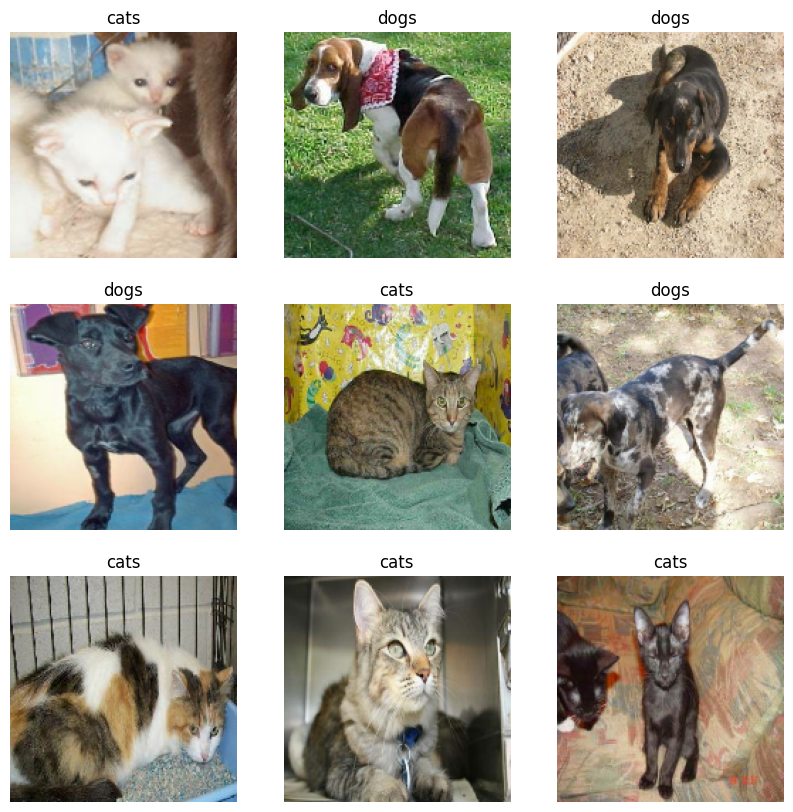

In [56]:
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")